### imports

In [73]:
import numpy as np
import sqlalchemy
import os
import requests
import fitz
import json
import torch
import joblib
import gzip
import csv
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm
from datasets import load_dataset
from sqlalchemy.engine import URL
from pgvector.sqlalchemy import Vector
from sqlalchemy import Integer, String, Float, Boolean, create_engine, select
from sqlalchemy.orm import DeclarativeBase, Mapped, mapped_column, Session
from sentence_transformers import SentenceTransformer
from itertools import islice


from pymilvus import MilvusClient
from pymilvus import FieldSchema, DataType, CollectionSchema

from google import genai

from typing import List, Optional

from pathlib import Path


In [74]:
def batched(iterable, n):
        "batched('ABCDEFG', 3) -> ABC DEF G"
        if n < 1:
            raise ValueError('n must be at least one')
        it = iter(iterable)
        while batch := tuple(islice(it, n)):
            yield batch

In [75]:
ROOT = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
META_CSV_GZ = ROOT / "images" / "metadata" / "images.csv.gz"
IMAGES_ROOT = ROOT / "images" / "small"

PG_HOST = os.environ.get("PG_HOST", "localhost")
PG_PORT = int(os.environ.get("PG_PORT", "5432"))
PG_DB = os.environ.get("PG_DB", "similarity_search_service_db")
PG_USER = os.environ.get("PG_USER", "postgres")
PG_PASS = os.environ.get("PG_PASS", "password")

MIN_SIZE = int(os.environ.get("ABO_MIN_SIZE", "1000"))
MAX_IMAGES = int(os.environ.get("MAX_IMAGES", "500"))
BATCH_SIZE = int(os.environ.get("BATCH_SIZE", str(joblib.cpu_count(only_physical_cores=True) or 4)))
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

### data preparation

In [76]:
def extract_image_paths_csv(meta_csv_gz: Path, images_root: Path, min_size: int) -> list[Path]:
    rows = []
    with gzip.open(meta_csv_gz, "rt", encoding="utf-8", newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            try:
                h = int(row["height"])
                w = int(row["width"])
            except (ValueError, KeyError):
                continue
            
            if h >= min_size and w >= min_size:
                p = images_root / row["path"]
                if p.exists():
                    rows.append(p)
    return rows

image_paths = extract_image_paths_csv(META_CSV_GZ, IMAGES_ROOT, MIN_SIZE)
print(f"Found {len(image_paths)} images with >= {MIN_SIZE}px.")

Found 7973 images with >= 1000px.


### Database setup

In [77]:
pg_url = URL.create(
    drivername="postgresql+psycopg",
    username=PG_USER,
    password=PG_PASS,
    host=PG_HOST,
    port=PG_PORT,
    database=PG_DB,
)
engine = sqlalchemy.create_engine(pg_url, echo=False, pool_pre_ping=True)

class Base(DeclarativeBase):
    pass

In [78]:
class Img(Base):
    __tablename__ = "images"
    __table_args__ = {'extend_existing': True}
    
    VECTOR_LENGTH: int = 512
    
    id: Mapped[int] = mapped_column(primary_key=True)
    image_path: Mapped[str] = mapped_column(sqlalchemy.Text, nullable=False, unique=True)
    embedding: Mapped[list[float]] = mapped_column(Vector(dim=VECTOR_LENGTH), nullable=False)
    
# Create table
Base.metadata.drop_all(engine)
Base.metadata.create_all(engine)


### Image vectorization

In [79]:
model = SentenceTransformer("clip-ViT-B-32", device=DEVICE)


def insert_images(engine, images):
    with Session(engine) as session:
        session.bulk_save_objects(images, return_defaults=False)
        session.commit()

def vectorize_images(engine, model, image_paths):
    image_paths_to_process = image_paths[:MAX_IMAGES]
    with tqdm(total=len(image_paths_to_process)) as pbar:
        for images_paths_batch in  batched(image_paths_to_process, BATCH_SIZE):
            paths_batch = list(images_paths_batch)
            images = [Image.open(path) for path in images_paths_batch]
            # calculate embeddings
            emb = model.encode(images, batch_size=len(images), convert_to_numpy=True, normalize_embeddings=True) 
            # create Img instances for all images in batch
            objs = [Img(image_path=str(p), embedding=emb[i].tolist()) for i, p in enumerate(paths_batch)]
            # insert all batch images
            insert_images(engine, objs)
            # update pbar
            pbar.update(len(objs))

vectorize_images(engine, model, image_paths)

100%|██████████| 500/500 [00:42<00:00, 11.85it/s]


### Search and results display

In [82]:

class ImageSearch:
    def __init__(self, engine, model):
        self.engine = engine
        self.model = model
        
    def __call__(self, image_description: str, k: int):
        found_images = self.find_similar_images(image_description, k)
        self.display_images(found_images)
        return found_images

    def find_similar_images(self, image_description: str, k: int):
        image_embedding = self.model.encode([image_description], convert_to_numpy=True, normalize_embeddings=True)[0]        
        # remember about session and commit
        with Session(self.engine) as session:

            query = (
                    select(Img)
                    .order_by(Img.embedding.cosine_distance(image_embedding))
                    .limit(k)
            )
        
        result = session.execute(query).scalars().all()
        return result
    
    def display_images(self, images):
        fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
        
        for i, img_path in enumerate(images):
            img = Image.open(img_path.image_path)
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(f"Image {i+1}")
        
        plt.show()
        

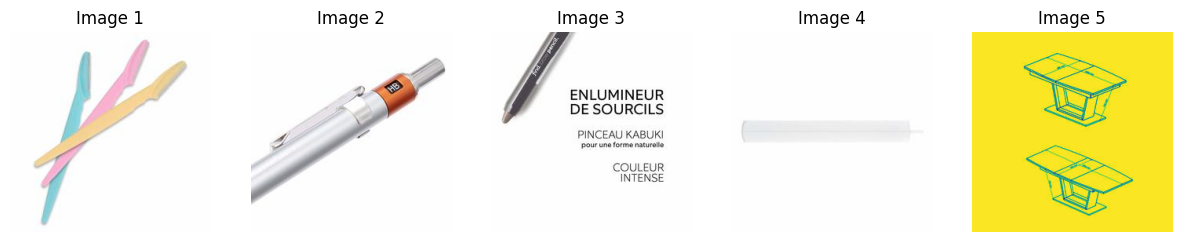

In [84]:
search = ImageSearch(engine, model)
res = search("pencil", k=5)